# Gaussian distribution parameter estimation

In this notebook, we try a parameter estimation for a Gaussian mixture model in Pystan. The model is borrowed from the [Stan users guide](https://mc-stan.org/docs/2_18/stan-users-guide/summing-out-the-responsibility-parameter.html). A workaround has been implemented because Stan is not able to work with discrete parameters, as explained in the users guide.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

Here, the model is defined in Stan.

In [47]:
gmm_code = """

data {
  int<lower=1> K;          // number of mixture components
  int<lower=1> N;          // number of data points
  real y[N];               // observations
}
parameters {
  simplex[K] theta;          // mixing proportions
  ordered[K] mu;             // locations of mixture components
  vector<lower=0>[K] sigma;  // scales of mixture components
}
model {
  vector[K] log_theta = log(theta);  // cache log calculation
  sigma ~ lognormal(0, 2);
  mu ~ normal(0, 10);
  for (n in 1:N) {
    vector[K] lps = log_theta;
    for (k in 1:K)
      lps[k] += normal_lpdf(y[n] | mu[k], sigma[k]);
    target += log_sum_exp(lps);
  }
}
"""
gmm = pystan.StanModel(model_code=gmm_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fb2493aa901419df5e616f1f31def94 NOW.


We specify our parameters and generate some data.

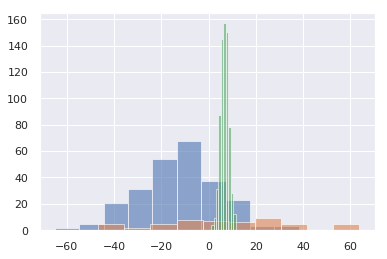

sample theta:  [0.26529314 0.06106118 0.67364568]
sample mu:  [-13.88871551  11.60674085   6.70260789]
sample sigma:  [17.18137507 30.782505    1.67126915]


In [146]:
N=1000
K=3
y_gmm = []
z_gmm = []
mu = np.random.normal(0,10,size=K)
sigmas = np.random.lognormal(0,2,size=K)
theta = np.random.dirichlet(np.ones(K))
for i in range(N):
    opt = np.random.choice(list(range(K)),p=theta)
    z_gmm.append(opt)
    y_gmm.append(np.random.normal(mu[opt],sigmas[opt]))
    
gmm_dat = {'N': N,'K': K,'y':y_gmm}

sns.set()
for k in range(K):
    plt.hist(np.array(y_gmm)[np.array(z_gmm)==k], alpha=0.6)
plt.show()

sample_theta = []
sample_sigma = []
sample_mu = []

for k in range(K):
    sample_theta.append(len(np.array(y_gmm)[np.array(z_gmm)==k])/N)
    sample_mu.append(np.mean(np.array(y_gmm)[np.array(z_gmm)==k]))
    sample_sigma.append(np.std(np.array(y_gmm)[np.array(z_gmm)==k]))

print('sample theta: ', theta)
print('sample mu: ', mu)
print('sample sigma: ', sigmas)

And then we can optimize our parameters and latent dataset.

In [147]:
fit = gmm.sampling(data=gmm_dat, chains=1, iter=200)
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]

In [148]:
theta_sim = fit_ext['theta'][best_ind]
mu_sim = fit_ext['mu'][best_ind]
sigmas_sim = fit_ext['sigma'][best_ind]


print('Sample theta: ',sample_theta)
print('Simulated theta: ',theta_sim)
print()
print('Sample mu: ',sample_mu)
print('Simulated mu: ',mu_sim)
print()
print('Sample sigmas: ',sample_sigma)
print('Simulated sigmas: ',sigmas_sim)

Sample theta:  [0.247, 0.052, 0.701]
Simulated theta:  [0.19089053 0.08243431 0.72667517]

Sample mu:  [-12.927190781924065, 7.0361325617117245, 6.711757870577708]
Simulated mu:  [-15.39545411   1.07123117   6.76791443]

Sample sigmas:  [16.62118108260775, 27.547482192817046, 1.7034660587286357]
Simulated sigmas:  [14.76051714 27.43974022  1.74041259]


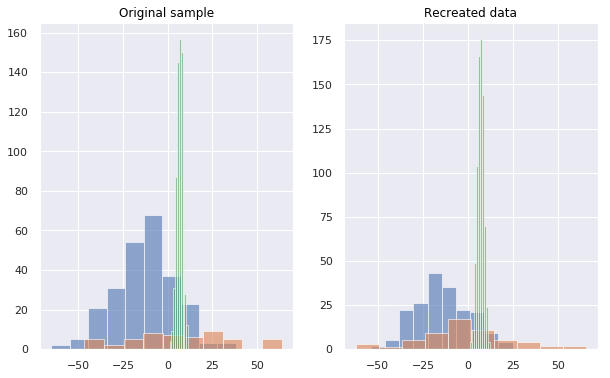

In [149]:
z_sim, y_sim = [], []
for i in range(N):
    opt = np.random.choice(list(range(K)),p=theta_sim)
    z_sim.append(opt)
    y_sim.append(np.random.normal(mu_sim[opt],sigmas_sim[opt]))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
for k in range(K):
    ax.hist(np.array(y_gmm)[np.array(z_gmm)==k], alpha=0.6)
# ax.set_xlim(min(np.min(y_gmm),np.min(y_sim)),max(np.max(y_gmm),np.max(y_sim)))
# ax.set_ylim((0,N/4))
title = ax.set_title("Original sample")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,2,2)
for k in range(K):
    ax.hist(np.array(y_sim)[np.array(z_sim)==k], alpha=0.6)
# ax.set_ylim((0,N/4))
# ax.set_xlim(min(np.min(y_gmm),np.min(y_sim)),max(np.max(y_gmm),np.max(y_sim)))
title = ax.set_title("Recreated data")
plt.setp(title, color='black') 
plt.show()

As we can see, all parameters are estimated accurately.